In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import tensorflow as tf
import pandas as pd
import seaborn as sns
import pickle
import zipfile
tf.__version__

'2.6.0-dev20210623'

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

array([1], dtype=uint8)

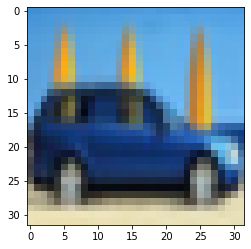

In [3]:
#X_train.shape
#y_train.shape
i = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[i])
y_train[i]

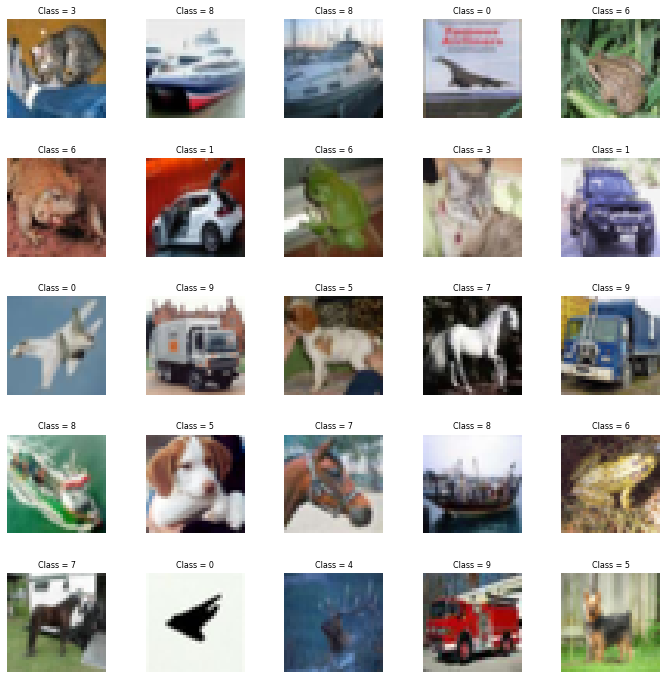

In [19]:
W_grid = 5
L_grid = 5
fig, axes = plt.subplots(L_grid, W_grid, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, W_grid * L_grid):
  axes[i].imshow(X_test[i].reshape((32,32,3)))
  axes[i].set_title(f"Class = {np.argmax(y_test[i])}", fontsize = 8)
  axes[i].axis('off')
plt.subplots_adjust(hspace=0.4);

In [4]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

categories = 10
y_train = tf.keras.utils.to_categorical(y_train, categories)
y_test = tf.keras.utils.to_categorical(y_test, categories)

In [6]:
X_train = X_train / 255
X_test = X_test / 255

In [7]:
cnn = tf.keras.Sequential()

cnn.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (32, 32, 3)))
cnn.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling2D(2,2))
cnn.add(tf.keras.layers.Dropout(0.3))

cnn.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
cnn.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling2D(2,2))
cnn.add(tf.keras.layers.Dropout(0.3))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(1024, activation = 'relu'))
cnn.add(tf.keras.layers.Dropout(0.3))

cnn.add(tf.keras.layers.Dense(1024, activation = 'relu'))

cnn.add(tf.keras.layers.Dense(10, activation = 'softmax'))
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0

In [8]:
cnn.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001, decay = 1e-6),
            loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [9]:
epochs = 100
epoch_history = cnn.fit(X_train, y_train, batch_size = 512, epochs = epochs)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
98/98 [==============================] - 24s 24ms/step - loss: 2.0935 - accuracy: 0.2231
Epoch 2/100
98/98 [==============================] - 2s 18ms/step - loss: 1.8702 - accuracy: 0.3220
Epoch 3/100
98/98 [==============================] - 2s 18ms/step - loss: 1.7594 - accuracy: 0.3651
Epoch 4/100
98/98 [==============================] - 2s 19ms/step - loss: 1.6889 - accuracy: 0.3892
Epoch 5/100
98/98 [==============================] - 2s 18ms/step - loss: 1.6356 - accuracy: 0.4068
Epoch 6/100
98/98 [==============================] - 2s 18ms/step - loss: 1.5886 - accuracy: 0.4235
Epoch 7/100
98/98 [==============================] - 2s 17ms/step - loss: 1.5473 - accuracy: 0.4409
Epoch 8/100
98/98 [==============================] - 2s 17ms/step - loss: 1.5082 - accuracy: 0.4509
Epoch 9/100
98/98 [==============================] - 2s 17ms/

In [10]:
epoch_history.history.keys()


dict_keys(['loss', 'accuracy'])

In [11]:
evaluation = cnn.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(evaluation[1]))

313/313 [==============================] - 2s 5ms/step - loss: 0.7115 - accuracy: 0.7663
Test Accuracy: 0.7663000226020813


In [13]:
def classify_prediction(pred): # np.argmax not working properly
    max = -1
    max_index = -1
    for i in range(0, pred.shape[0]):
        if pred[i] > max:
            max = pred[i]
            max_index = i
    return max_index

def predict_classes(pred):
    classes = np.empty(shape=(pred.shape[0],))
    for i in range(0, pred.shape[0]):
        classes[i] = classify_prediction(pred[i])
    return np.array(classes, dtype='float32')

In [15]:
predictions = cnn.predict(X_test)
pred_classes = predict_classes(predictions)

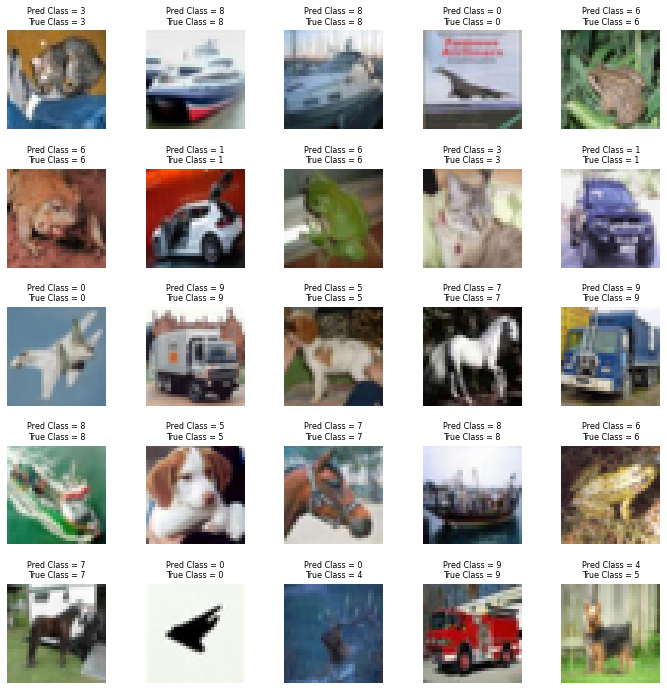

In [21]:
W_grid = 5
L_grid = 5
fig, axes = plt.subplots(L_grid, W_grid, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, W_grid * L_grid):
  axes[i].imshow(X_test[i].reshape((32,32,3)))
  axes[i].set_title(f"Pred Class = {int(pred_classes[i])}\nTrue Class = {np.argmax(y_test[i])}", fontsize = 8)
  axes[i].axis('off')
plt.subplots_adjust(hspace=0.4);

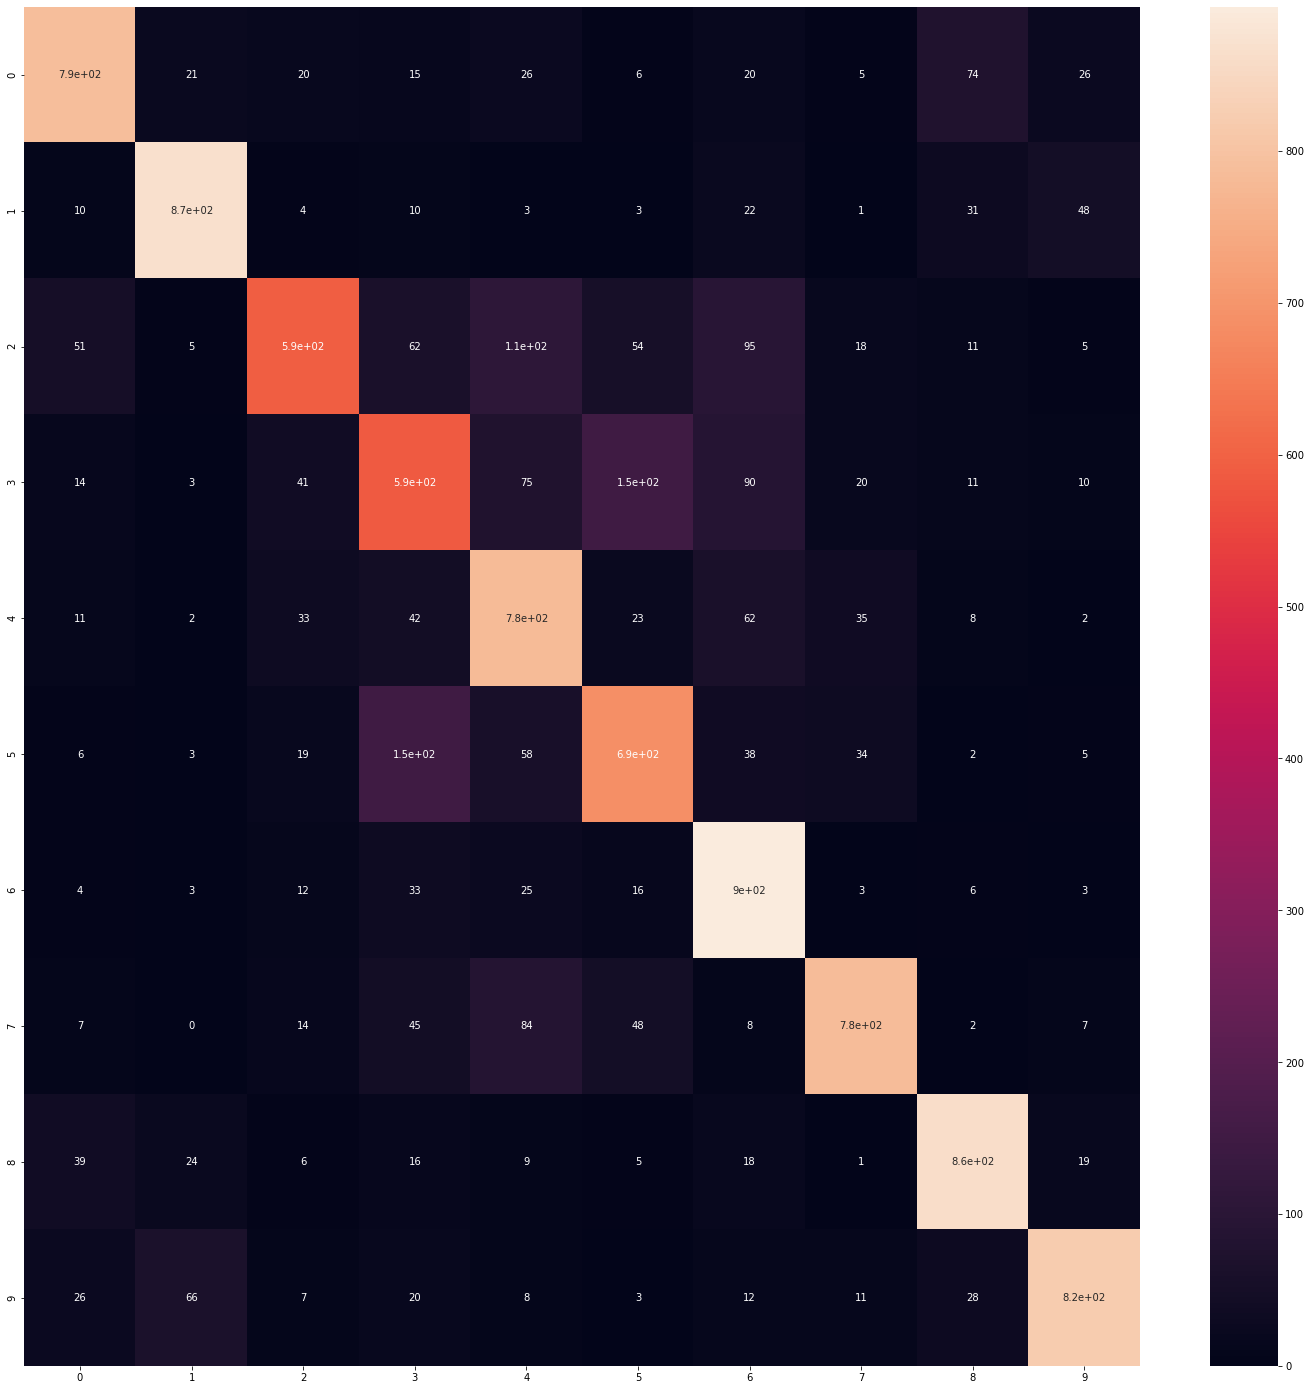

In [27]:
from sklearn.metrics import confusion_matrix
y_classes = [np.argmax(y) for y in y_test]
cm = confusion_matrix(y_classes, pred_classes)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True);

In [29]:
from sklearn.metrics import classification_report
num_classes = 10
target_names = ["Class {}".format(int(i)) for i in range(num_classes)]
print(classification_report(y_classes, pred_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.82      0.79      0.81      1000
     Class 1       0.87      0.87      0.87      1000
     Class 2       0.79      0.59      0.68      1000
     Class 3       0.60      0.59      0.59      1000
     Class 4       0.66      0.78      0.72      1000
     Class 5       0.69      0.69      0.69      1000
     Class 6       0.71      0.90      0.79      1000
     Class 7       0.86      0.79      0.82      1000
     Class 8       0.83      0.86      0.85      1000
     Class 9       0.87      0.82      0.84      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000

